Initialise values

In [219]:
from enum import Enum
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np

P_STRAIGHT = 0.8
P_LEFT = 0.1
P_RIGHT = 0.1

DISCOUNT = 0.99
# Defines the threshold for convergence
THRESHOLD_THETA = 0.001
MAX_ITERATIONS = 800
SAMPLING_INTERVAL = 100

ROWS = 6
COLS = 6

START_COORDS = (2, 2)

# Enum to define actions that agent can take
class Actions(Enum):
    UP = 0
    RIGHT = 90
    DOWN = 180
    LEFT = 270
    NONE = -1
    def prev(self):
        cls = self.__class__
        members = list(cls)
        index = members.index(self) - 1
        if index < 0:
            index = len(members)-2
        return members[index]

    def next(self):
        cls = self.__class__
        members = list(cls)
        index = members.index(self) + 1
        if index >= len(members) - 1:
            index = 0
        return members[index]

# Define cell types in grid world and corresponding rewards
class CellType(Enum):
    WALL = 0, 0
    WHITE = 1, -0.05
    GREEN = 2, 1
    BROWN = 3, -1
    BLUE = 4, 3
    RED = 5, -3

    def __new__(cls, value, reward):
        member = object.__new__(cls)
        member._value_ = value
        member.reward = Decimal(reward)
        return member

    def _int__(self):
        return self.value

### Grid class to simulate Tileworld

In [220]:
# Define Grid class to simulate Tileworld
class Grid():
    # Define grid
    # Default initialisation
    def __init__(self):
        self.grid = [[CellType.WHITE for j in range(COLS)] for i in range(ROWS)]
        self.utilities = [[0 for j in range(COLS)] for i in range(ROWS)]
        self.policies = [[Actions.NONE for j in range(COLS)] for i in range(ROWS)];

    def get_utilities(self):
        return self.utilities

    def initialise_values(self, value: int):
        self.utilities = [[value for j in range(COLS)] for i in range(ROWS)]

    def initialise_policies(self, action: Actions):
        self.policies = [[action for j in range(COLS)] for i in range(ROWS)];

    def get_policies(self):
        return self.policies

    def update_policies(self, policies):
        self.policies = [r[:] for r in policies]

    def update_utilities(self, utilities):
        self.utilities = [r[:] for r in utilities]
    
    def initialise(self, green_cells, brown_cells, wall_cells, blue_cells = [], red_cells = []):
        for r, c in green_cells:
            self.grid[r][c] = CellType.GREEN
        for r, c in brown_cells:
            self.grid[r][c] = CellType.BROWN
        for r, c in wall_cells:
            self.grid[r][c] = CellType.WALL
        for r, c in red_cells:
            self.grid[r][c] = CellType.RED
        for r, c in blue_cells:
            self.grid[r][c] = CellType.BLUE

    def get_reward(self, r, c):
        return self.grid[r][c].reward
    
    def get_state(self, r, c) -> CellType:
        return self.grid[r][c]
    
    def get_utility(self, r, c) -> int:
        return self.utilities[r][c]

    # Function to get utility of next state and immediate reward
    def get_next_state(self, r: int, c: int, action: Actions):
        new_r, new_c = r, c
        if action == Actions.UP:
            if r != ROWS-1:
                new_r += 1
        elif action == Actions.RIGHT:
            if c != COLS-1:
                new_c += 1
        elif action == Actions.LEFT:
            if c != 0:
                new_c -= 1
        elif action == Actions.DOWN:
            if r != 0:
                new_r -= 1
        
        # if hit wall or stay in place
        if self.grid[new_r][new_c] == CellType.WALL:
            return self.utilities[r][c]
        return self.utilities[new_r][new_c]
        
    def update_utility(self, r, c, utility):
        self.utilities[r][c] = utility


### Helper Functions 

In [221]:
# Function to calculate expected utility
def get_expected_utility(reward, utility_list, prob_list):
    result = Decimal(reward)

    for i in range(len(prob_list)):
        result += Decimal(DISCOUNT) * Decimal(utility_list[i]) * Decimal(prob_list[i])

    return result

# Functiion to print 2D array (policy or utility map)
def print_2d_arr(arr):
    for r in range(len(arr)-1, -1, -1):
        line = ""
        for c in range(len(arr[0])):
            if (isinstance(arr[r][c], Decimal)):
                # line += " " + str(round(arr[r][c], 1))
                line += " " + str(round(arr[r][c], 1))
            elif (isinstance(arr[r][c], Actions)):
                line += " " + str(arr[r][c].name)
            else:
                line += " " + str(arr[r][c])
        print(line + "\n")

# Function to get average utility in 2D array
def get_avg_utility(arr):
    total = 0
    for r in range(len(arr)-1, -1, -1):
        for c in range(len(arr[0])):
            total += arr[r][c]
    
    return Decimal(total / (len(arr)) * (len(arr[0])))

### Value Iteration Function

In [222]:
def value_iteration(grid: Grid, iterations: int = MAX_ITERATIONS, complete_iter: bool = False):
    # Initialise all values to 0
    grid.initialise_values(0)
    utility_map = [r[:] for r in grid.get_utilities()]
    policy_map = [r[:] for r in grid.get_policies()]
    iter = 0
    # Max diff
    theta = float("inf")
    # Continue iteration until maximum difference between iterations less than threshold difference
    
    for _ in range(iterations):
        theta = -float("inf")
        for r in range(ROWS):
            for c in range(COLS):
                if grid.get_state(r, c) == CellType.WALL:
                    continue

                # Get optimal value and policy
                v_max = -float("inf")
                a_max = Actions.UP
                for a in Actions:
                    if a == Actions.NONE:
                        continue
                    
                    reward = grid.get_reward(r, c)
                    # Get expected future utility and immediate reward
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                    
                    # Calculate expected utility
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])
                    if(v > v_max):
                        a_max = a
                        v_max = v

                # Get current value
                v_curr = grid.get_utility(r, c)

                # Get max diff
                theta = max(theta, (abs(v_curr - v_max)))
                utility_map[r][c] = v_max
                policy_map[r][c] = a_max.name
        iter += 1
        # Update utilities stored in grid at end of iteration
        grid.update_utilities(utility_map)

        # Break when convergence if iterations not completed
        if not complete_iter and theta < THRESHOLD_THETA:
            break

    return policy_map, utility_map 

### Policy Iteration Function

In [223]:
# Policy Iteration
def policy_iteration(grid: Grid, iterations: int = MAX_ITERATIONS, complete_iter: bool = False):
    # Initialise policy
    grid.initialise_policies(Actions.UP)
    grid.initialise_values(0)

    policy_map = [r[:] for r in grid.get_policies()]
    utility_map = [r[:] for r in grid.get_utilities()]
    iter = 0

    # Set limit  of 1000
    for _ in range(iterations):
        # Policy Evaluation
        # for i in range(2):

        theta = float("inf")
        while theta > THRESHOLD_THETA:
            theta = -float("inf")
            for r in range(ROWS):
                for c in range(COLS):
                    if grid.get_state(r, c) == CellType.WALL:
                        policy_map[r][c] = Actions.NONE
                        continue
                    a = policy_map[r][c]
                    
                    reward = grid.get_reward(r, c)
                    # Policy evaluation
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                        
                    # Calculate expected utility
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])

                    # Get current value
                    v_prev = grid.get_utility(r, c)

                    # Get max diff
                    theta = max(theta, (abs(v_prev - v)))
                    utility_map[r][c] = v
            grid.update_utilities(utility_map)
        
        # for r in range(ROWS):
        #     for c in range(COLS):
        #         if grid.get_state(r, c) == CellType.WALL:
        #             policy_map[r][c] = Actions.NONE
        #             continue
        #         a = policy_map[r][c]

        #         reward = grid.get_reward(r, c)
        #         # Policy evaluation
        #         u_1 = grid.get_next_state(r, c, a) # Straight
        #         u_2 = grid.get_next_state(r, c, a.prev()) # Left
        #         u_3 = grid.get_next_state(r, c, a.next()) # Right
                    
        #         # Calculate expected utility
        #         v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])

        #         # Get current value
        #         # v_prev = grid.get_utility(r, c)

        #         # Get max diff
        #         # theta = max(theta, (abs(v_prev - v)))
        #         utility_map[r][c] = v
        # grid.update_utilities(utility_map)
        
        # Policy Improvement
        policy_stable = True
        for r in range(ROWS):
            for c in range(COLS):
                a_prev = policy_map[r][c]

                if grid.get_state(r, c) == CellType.WALL:
                    policy_map[r][c] == Actions.NONE
                    continue

                v_max = -float("inf")
                a_max = Actions.UP

                for a in Actions:
                    if a == Actions.NONE:
                        continue
                    
                    reward = grid.get_reward(r, c)
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                        
                    # Calculate expected utility
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])

                    # Get best action
                    if v > v_max:
                        v_max = v
                        a_max = a

                if a_prev != a_max:
                    policy_stable = False
                policy_map[r][c] = a_max
        grid.update_policies(policy_map)

        # Break when policies converge if no need to complete iterations
        if not complete_iter and policy_stable:
            break
        iter += 1
    
    return policy_map, utility_map

# Part 1

### Definition of Gridworld 

In [224]:
# Define grid cells
green_cells = [(5, 0), (5, 2), (5, 5), (4, 3), (3, 4), (2, 5)]
brown_cells = [(4, 1), (4, 5), (3, 2), (2, 3), (1, 4)]
wall_cells = [(5, 1), (4, 4), (1, 1), (1, 2), (1, 3)]
grid = Grid()

# Initialise grid with values
grid.initialise(green_cells, brown_cells, wall_cells)

# green_cells = [(0, 0)]
# blue_cells = [(3, 5)]
# brown_cells = [(5, 1), (0, 1), (0, 4), (0, 5), (4, 4)]
# wall_cells = [(0, 3), (2, 3), (3, 3), (4, 3)]
# grid = Grid()
# grid.initialise(green_cells, brown_cells, wall_cells, blue_cells=blue_cells)

### Value Iteration of Given Gridworld

In [225]:
# Perform value iteration to retrieve optimal policies and utilities for all cells
policy_map, utility_map = value_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)


======== OPTIMAL POLICIES ======== 

 UP NONE LEFT LEFT LEFT UP

 UP LEFT LEFT LEFT NONE UP

 UP LEFT LEFT UP LEFT LEFT

 UP LEFT LEFT UP UP UP

 UP NONE NONE NONE UP UP

 UP LEFT LEFT LEFT UP UP

======== OPTIMAL UTILITIES ======== 

 99.9 0 94.9 93.7 92.5 93.2

 98.3 95.8 94.4 94.3 0 90.8

 96.8 95.5 93.2 93.0 93.0 91.6

 95.4 94.3 93.1 91.0 91.7 91.7

 94.2 0 0 0 89.4 90.4

 92.8 91.6 90.3 89.2 88.4 89.1



### Plotting Utility Estimates 

#### Sampling Utility Estimates

In [226]:
# In intervals of 100, perform value iteration and get utility estimate for each state
utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
iteration_values = []

# Add to graph
for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
    _, utility_map = value_iteration(grid, i, True)
    for r in range(ROWS):
        for c in range(COLS):
            utility_estimates[r][c].append(utility_map[r][c])
    iteration_values.append(i)

#### Plotting Graphs

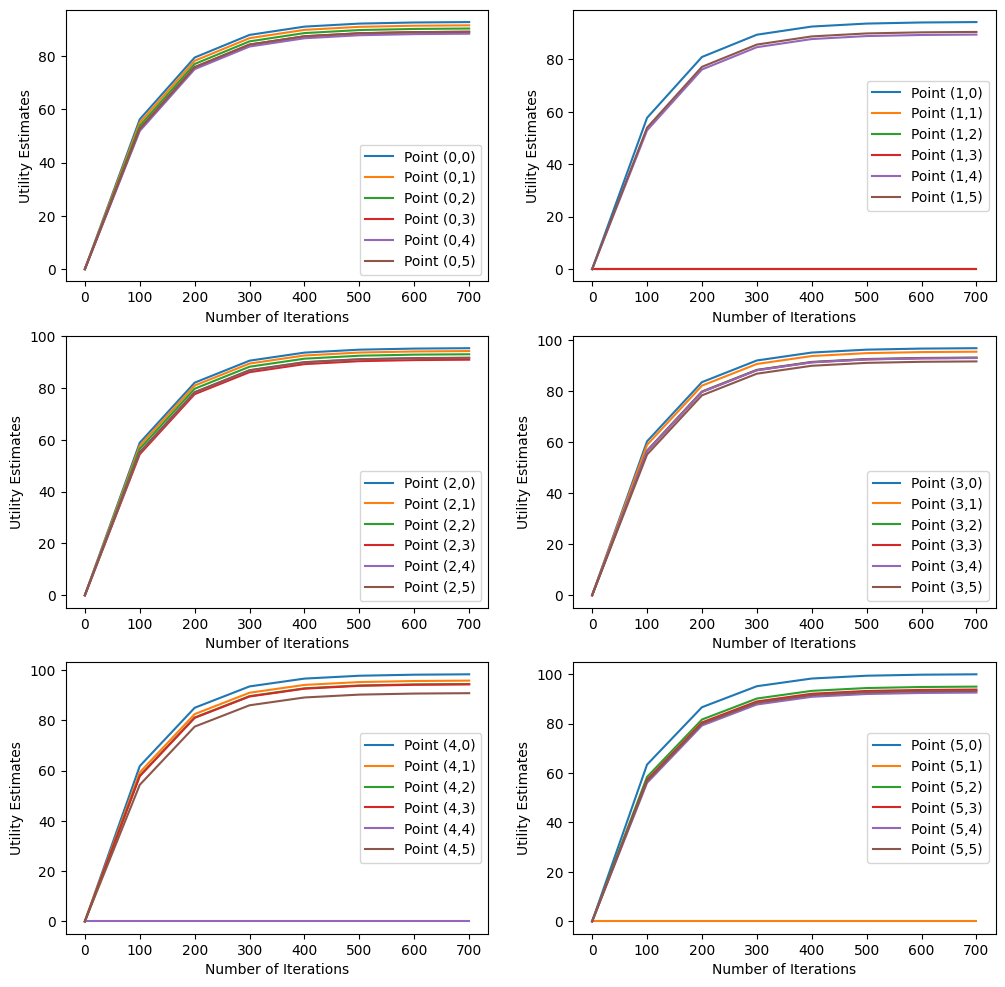

In [227]:
# For each cell in the grid, plot its utility estimate at each interval
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)

iteration_values_np = np.array(iteration_values)
for r in range(ROWS):
    for c in range(COLS):
        # Plot all cols in this row
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()


### Policy Iteration of Given Gridworld

In [228]:
policy_map, utility_map = policy_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 UP NONE LEFT LEFT LEFT UP

 UP LEFT LEFT LEFT NONE UP

 UP LEFT LEFT UP LEFT LEFT

 UP LEFT LEFT UP UP UP

 UP NONE NONE NONE UP UP

 UP LEFT LEFT LEFT UP UP

======== OPTIMAL UTILITIES ======== 

 100.0 0 95.0 93.8 92.6 93.3

 98.4 95.9 94.5 94.4 0 90.9

 96.9 95.5 93.3 93.1 93.1 91.7

 95.5 94.4 93.2 91.1 91.8 91.8

 94.3 0 0 0 89.5 90.5

 92.9 91.7 90.4 89.3 88.5 89.2



### Plotting Utility Estimates

#### Sampling Utility Estimates

In [229]:
# In intervals of 100, perform value iteration and get utility estimate for each state
utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
iteration_values = []

# Add to graph
for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
# for i in range(:
    _, utility_map = policy_iteration(grid, i, True)
    for r in range(ROWS):
        for c in range(COLS):
            utility_estimates[r][c].append(utility_map[r][c])
    iteration_values.append(i)

#### Plotting Graphs

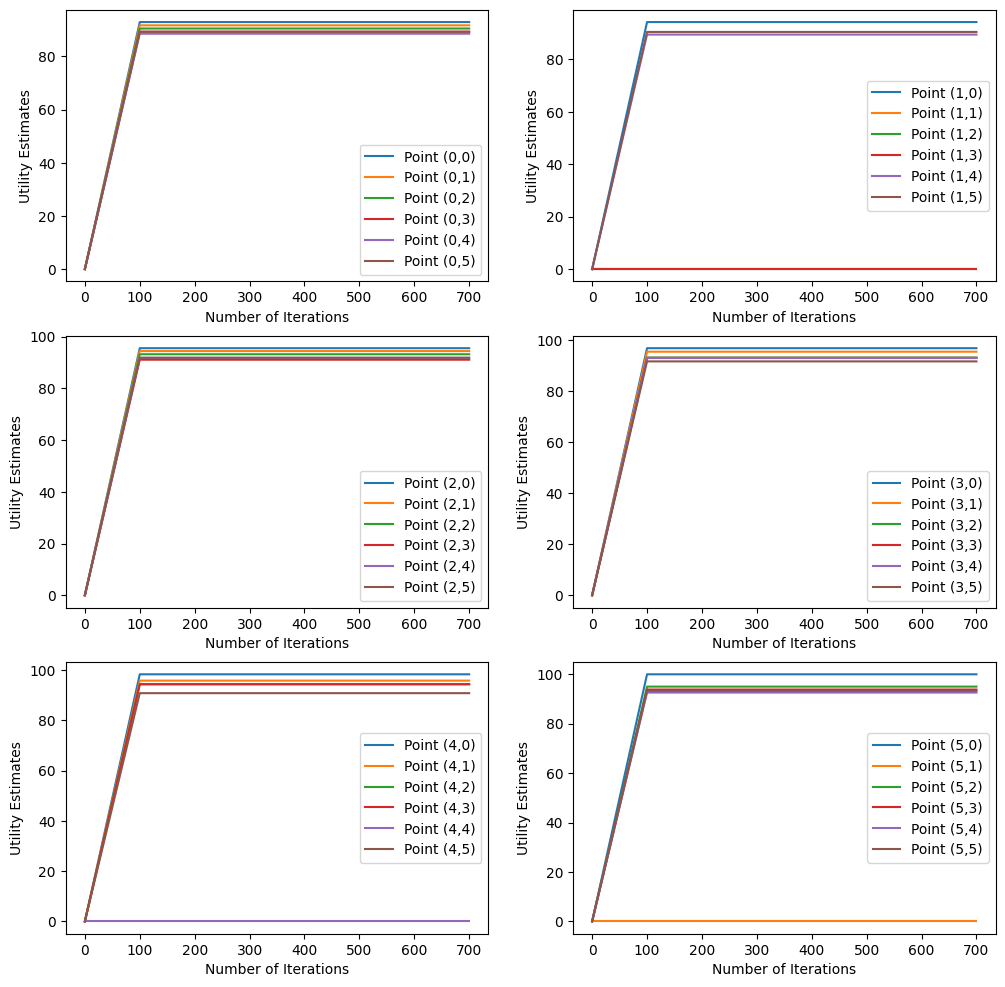

In [230]:
# For each cell in the grid, plot its utility estimate at each interval
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)

iteration_values_np = np.array(iteration_values)
for r in range(ROWS):
    for c in range(COLS):
        # Plot all cols in this row
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()

# Part 2

### Definition of New Gridworld

The new, more complex Gridworld has 2 new square types, Blue and Red.

Blue squares give a reward of +3, while red squares give a reward of -3.

In [231]:
green_cells = [(4, 0), (0, 1), (2, 4)]
blue_cells = [(2, 0), (5, 1), (1, 0), (1, 5), (4, 3), (5, 4)]
brown_cells = [(1, 0), (3, 0), (0, 2), (3, 3)]
red_cells = [(3, 2), (0, 4), (4, 5)]
wall_cells = [(2, 1), (0, 3), (3, 4), (4, 4), (5, 2)]

grid = Grid()
grid.initialise(green_cells, brown_cells, wall_cells, blue_cells, red_cells)

### Value Iteration of New Gridworld

In [232]:
# Perform value iteration to retrieve optimal policies and utilities for all cells
policy_map, utility_map = value_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 DOWN RIGHT NONE DOWN LEFT LEFT

 DOWN LEFT LEFT LEFT NONE UP

 DOWN LEFT LEFT UP NONE DOWN

 DOWN NONE DOWN DOWN LEFT DOWN

 UP LEFT LEFT LEFT LEFT LEFT

 UP LEFT LEFT NONE UP UP

======== OPTIMAL UTILITIES ======== 

 270.3 273.2 0 263.0 263.5 259.3

 273.4 270.5 266.9 266.4 0 252.3

 276.0 272.2 265.7 262.2 0 257.9

 281.2 0 269.0 265.7 263.8 261.2

 280.9 277.1 272.9 269.0 264.6 264.2

 277.1 275.2 270.7 0 257.9 260.6



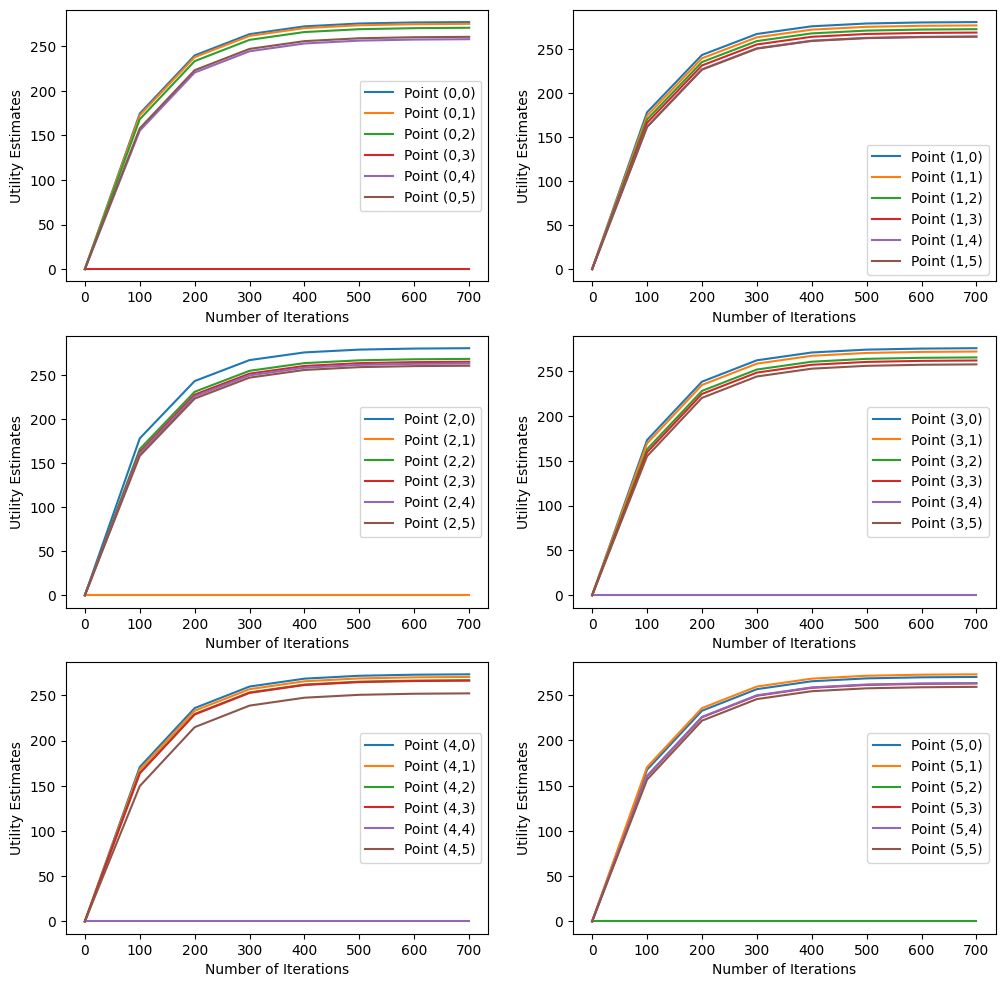

In [233]:
# In intervals of 100, perform value iteration and get utility estimate for each state
utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
iteration_values = []

# Add to graph
for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
    _, utility_map = value_iteration(grid, i, True)
    for r in range(ROWS):
        for c in range(COLS):
            utility_estimates[r][c].append(utility_map[r][c])
    iteration_values.append(i)

# For each cell in the grid, plot its utility estimate at each interval
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)

iteration_values_np = np.array(iteration_values)
for r in range(ROWS):
    for c in range(COLS):
        # Plot all cols in this row
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()

### Policy Iteration of New Gridworld

In [234]:
policy_map, utility_map = policy_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 DOWN RIGHT NONE DOWN LEFT LEFT

 DOWN LEFT LEFT LEFT NONE UP

 DOWN LEFT LEFT UP NONE DOWN

 DOWN NONE DOWN DOWN LEFT DOWN

 UP LEFT LEFT LEFT LEFT LEFT

 UP LEFT LEFT NONE UP UP

======== OPTIMAL UTILITIES ======== 

 270.3 273.2 0 263.1 263.6 259.4

 273.5 270.5 266.9 266.4 0 252.4

 276.0 272.3 265.7 262.3 0 257.9

 281.2 0 269.1 265.8 263.8 261.3

 281.0 277.2 272.9 269.1 264.7 264.3

 277.2 275.2 270.8 0 258.0 260.6



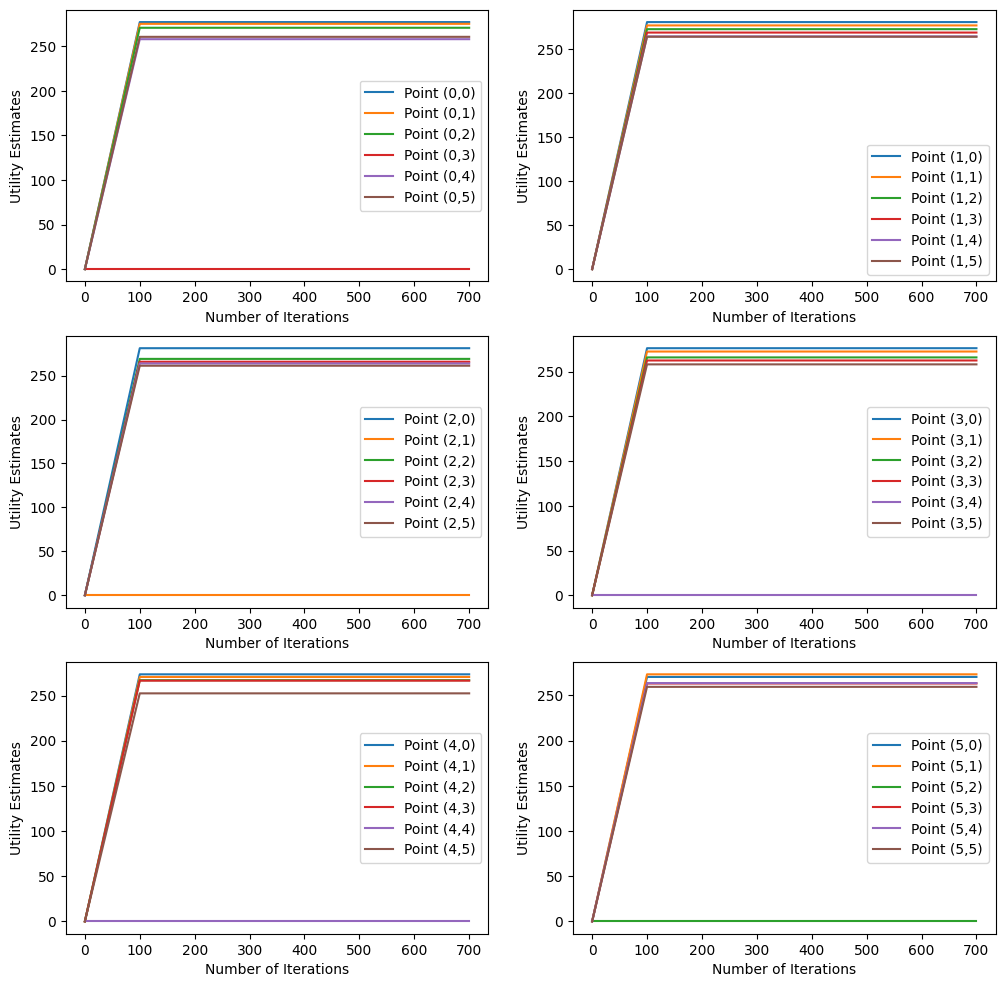

In [235]:
# In intervals of 100, perform value iteration and get utility estimate for each state
utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
iteration_values = []

# Add to graph
for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
    _, utility_map = policy_iteration(grid, i, True)
    for r in range(ROWS):
        for c in range(COLS):
            utility_estimates[r][c].append(utility_map[r][c])
    iteration_values.append(i)

# For each cell in the grid, plot its utility estimate at each interval
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)

iteration_values_np = np.array(iteration_values)
for r in range(ROWS):
    for c in range(COLS):
        # Plot all cols in this row
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()